In [1]:
import numpy as np
import cProfile
from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import csr_matrix
from mean_field_model import Dipole_model
import random
from direct_sum import Direct_sum_Dipole_model
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Particle radius is unit length 50 nm

R = 1

# Calculate the lattice constant of hexagonal lattice

a_list = [4, 6, 8, 9, 10, 11, 12, 13, 14]
# Generate the lattice positions
N = 20*20
position = np.zeros((N,3))
a = a_list[0]
for i in range(20):
    for j in range(20):
        position[i*20+j] = np.array([i*a,j*a*np.sqrt(3)/2,0])
N_small = 5*5
position_array_small = np.zeros((N_small,3))
for i in range(5):
    for j in range(5):
        position_array_small[i*5+j] = np.array([i*a,j*a*np.sqrt(3)/2,0])
box = np.array([5*a,5*a*np.sqrt(3)/2,0])
# wavevectors 

lambda_array = np.linspace(6,14,100)

k_array = 2*np.pi/lambda_array
k_vec_array = np.zeros((100, 3))
k_vec_array[:,2] = k_array
# polarizability

eps_medium = 1


In [3]:
optical_df = pd.read_csv('utils/silver.csv')


In [4]:
optical_df

,wl,n
0,0.1879,1.07
1,0.1916,1.10
2,0.1953,1.12
3,0.1993,1.14
4,0.2033,1.15
...,...,...
94,1.0880,7.795
95,1.2160,8.828
96,1.3930,10.10
97,1.6100,11.85


In [5]:
n_data = optical_df.iloc[:49]
k_data = optical_df.iloc[49:]

In [6]:
k_data.columns = k_data.iloc[0]
k_data = k_data.iloc[1:].reset_index(drop=True)
# Merge n_data and k_data on wavelength column
optical_data = pd.merge(n_data, k_data, on='wl')
optical_data.columns = ['wl', 'n', 'k'] # Rename columns for clarity


In [7]:
# Calculate complex dielectric function components
optical_data['n'] = optical_data['n'].astype(float)
optical_data['k'] = optical_data['k'].astype(float)
optical_data['e1'] = optical_data['n']**2 - optical_data['k']**2  # Real part
optical_data['e2'] = 2 * optical_data['n'] * optical_data['k']    # Imaginary part
optical_data


,wl,n,k,e1,e2
0,0.1879,1.07,1.212,-0.324044,2.59368
1,0.1916,1.10,1.232,-0.307824,2.71040
2,0.1953,1.12,1.255,-0.320625,2.81120
3,0.1993,1.14,1.277,-0.331129,2.91156
4,0.2033,1.15,1.296,-0.357116,2.98080
5,0.2073,1.18,1.312,-0.328944,3.09632
6,0.2119,1.20,1.325,-0.315625,3.18000
7,0.2164,1.22,1.336,-0.296496,3.25984
8,0.2214,1.25,1.342,-0.238464,3.35500
9,0.2262,1.26,1.344,-0.218736,3.38688


In [8]:
optical_data['wl'] = optical_data['wl'].astype(float)
optical_data['wl_normalized'] = optical_data['wl']/0.05




In [9]:
# Create interpolation functions for n and k using the normalized wavelength data
from scipy.interpolate import interp1d

n_interp = interp1d(optical_data['wl_normalized'], optical_data['n'], kind='cubic')
k_interp = interp1d(optical_data['wl_normalized'], optical_data['k'], kind='cubic')

# Calculate n and k values for lambda_array 
n_values = n_interp(lambda_array)
k_values = k_interp(lambda_array)

# Store interpolated values in a new dataframe
interpolated_optical_data = pd.DataFrame({
    'lambda': lambda_array,
    'n': n_values,
    'k': k_values
})


In [10]:
interpolated_optical_data['e1'] = interpolated_optical_data['n']**2 - interpolated_optical_data['k']**2  # Real part
interpolated_optical_data['e2'] = 2 * interpolated_optical_data['n'] * interpolated_optical_data['k']    # Imaginary part

In [11]:
e1_array = interpolated_optical_data['e1'].to_numpy()
e2_array = interpolated_optical_data['e2'].to_numpy()
e_array = e1_array + 1j*e2_array





In [12]:
interpolated_optical_data

,lambda,n,k,e1,e2
0,6.000000,1.350942,0.990109,0.844728,2.675159
1,6.080808,1.286456,0.863143,0.909953,2.220790
2,6.161616,1.194404,0.716709,0.912930,1.712080
3,6.242424,1.095506,0.561042,0.885366,1.229250
4,6.323232,0.984975,0.429645,0.785581,0.846380
...,...,...,...,...,...
95,13.676768,0.043988,4.673165,-21.836537,0.411130
96,13.757576,0.043229,4.705261,-22.137608,0.406807
97,13.838384,0.042481,4.737446,-22.441593,0.402506
98,13.919192,0.041724,4.769700,-22.748298,0.398027


In [13]:
q_array = 2*np.pi/lambda_array
alpha_array = ((1-0.1*(e_array+1)*q_array**2)*4*np.pi/3)/((1/(e_array-1)+1/3)-((e_array+10)*(q_array**2)/30)-4*1j*np.pi**2*4*np.pi/(9*lambda_array**3))

In [14]:
single_extinction_array = 4*np.pi* k_array*np.imag(alpha_array)


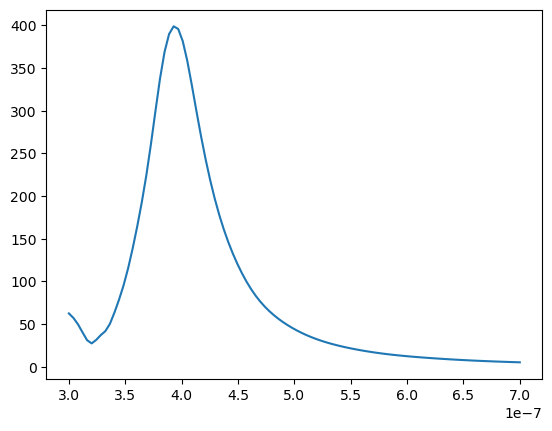

In [15]:

plt.plot(lambda_array*50*10**-9,single_extinction_array)


In [ ]:
# dipole model
dipole_array = np.zeros((100,25,3,2),dtype=complex)
for i in range(100):
    alpha = alpha_array[i]
    k = k_vec_array[i]
    dipole_moment = Dipole_model(position_array_small, alpha, box,k)
    dipole_array[i] = dipole_moment
    

[0.        +0.j         1.14044584+4.73857451j 0.        +0.j
 0.        +0.j         1.14044584+4.73857451j 0.        +0.j
 0.        +0.j         1.14044584+4.73857451j 0.        +0.j
 0.        +0.j         1.14044584+4.73857451j 0.        +0.j
 0.        +0.j         1.14044584+4.73857451j 0.        +0.j
 0.        +0.j         1.14044584+4.73857451j 0.        +0.j
 0.        +0.j         1.14044584+4.73857451j 0.        +0.j
 0.        +0.j         1.14044584+4.73857451j 0.        +0.j
 0.        +0.j         1.14044584+4.73857451j 0.        +0.j
 0.        +0.j         1.14044584+4.73857451j 0.        +0.j
 0.        +0.j         1.14044584+4.73857451j 0.        +0.j
 0.        +0.j         1.14044584+4.73857451j 0.        +0.j
 0.        +0.j         1.14044584+4.73857451j 0.        +0.j
 0.        +0.j         1.14044584+4.73857451j 0.        +0.j
 0.        +0.j         1.14044584+4.73857451j 0.        +0.j
 0.        +0.j         1.14044584+4.73857451j 0.        +0.j
 0.     

In [106]:
k_hat = np.array([0,0,1])
# Using [1,0,0] unless k_hat is parallel to it
temp_vec = [1,0,0] if not np.allclose(np.abs(k_hat), [1,0,0]) else [0,1,0]
E1 = np.cross(k_hat, temp_vec)
E1 = E1 / np.linalg.norm(E1)
    
# Find second perpendicular vector using cross product
E2 = np.cross(k_hat, E1)
E2 = E2 / np.linalg.norm(E2)
E0 = np.array([E1,E2])

In [107]:
dipole_array

array([[[[  0.        +0.j        ,  -1.06988223-4.59677122j],
         [  1.06988223+4.59677122j,   0.        +0.j        ],
         [  0.        +0.j        ,   0.        +0.j        ]],

        [[  0.        +0.j        ,  -1.06988223-4.59677122j],
         [  1.06988223+4.59677122j,   0.        +0.j        ],
         [  0.        +0.j        ,   0.        +0.j        ]],

        [[  0.        +0.j        ,  -1.06988223-4.59677122j],
         [  1.06988223+4.59677122j,   0.        +0.j        ],
         [  0.        +0.j        ,   0.        +0.j        ]],

        ...,

        [[  0.        +0.j        ,  -1.06988223-4.59677122j],
         [  1.06988223+4.59677122j,   0.        +0.j        ],
         [  0.        +0.j        ,   0.        +0.j        ]],

        [[  0.        +0.j        ,  -1.06988223-4.59677122j],
         [  1.06988223+4.59677122j,   0.        +0.j        ],
         [  0.        +0.j        ,   0.        +0.j        ]],

        [[  0.        +0.j     

In [108]:
extinction_array = np.zeros((100))
for i in range(100):
    
    dipole_moment = dipole_array[i]
    extinction_1 = 0

    for j in range(2):
        E = E0[j]
        for k in range(25):
        
            extinction_1 += 4*np.pi*k_array[i]*(np.imag(np.dot(E,dipole_moment[k,:,j])))
    extinction_1 = extinction_1/50
    extinction_array[i] = extinction_1

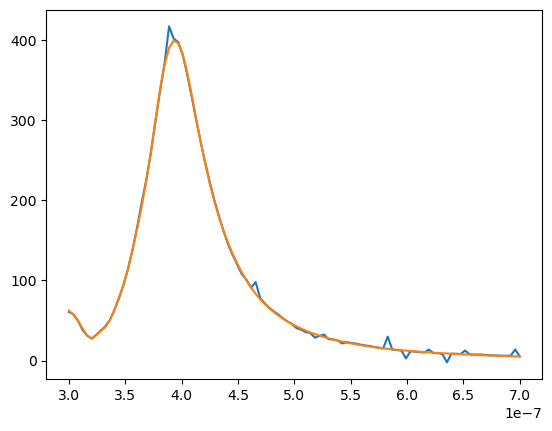

In [109]:
plt.plot(lambda_array*50*10**-9,extinction_array)
plt.plot(lambda_array*50*10**-9,single_extinction_array)


In [62]:
alpha_array.shape

(100,)

In [65]:
dipole_array[0,0,1,0]

np.complex128(1.1359193707537636+4.74235362107103j)

In [84]:
# direct sum dipole model
dipole_array_direct = np.zeros((100,25,3,2),dtype=complex)
for i in range(100):
    print(i)
    alpha = alpha_array[i]
    k = k_vec_array[i]
    dipole_moment = Direct_sum_Dipole_model(position_array_small, alpha, k)
    dipole_array_direct[i] = dipole_moment

0
[[0.        +0.j         1.14044584+4.73857451j 0.        +0.j        ]
 [0.        +0.j         1.14044584+4.73857451j 0.        +0.j        ]
 [0.        +0.j         1.14044584+4.73857451j 0.        +0.j        ]
 [0.        +0.j         1.14044584+4.73857451j 0.        +0.j        ]
 [0.        +0.j         1.14044584+4.73857451j 0.        +0.j        ]
 [0.        +0.j         1.14044584+4.73857451j 0.        +0.j        ]
 [0.        +0.j         1.14044584+4.73857451j 0.        +0.j        ]
 [0.        +0.j         1.14044584+4.73857451j 0.        +0.j        ]
 [0.        +0.j         1.14044584+4.73857451j 0.        +0.j        ]
 [0.        +0.j         1.14044584+4.73857451j 0.        +0.j        ]
 [0.        +0.j         1.14044584+4.73857451j 0.        +0.j        ]
 [0.        +0.j         1.14044584+4.73857451j 0.        +0.j        ]
 [0.        +0.j         1.14044584+4.73857451j 0.        +0.j        ]
 [0.        +0.j         1.14044584+4.73857451j 0.        +0.j

KeyboardInterrupt: 

In [ ]:
extinction_array_direct = np.zeros((100))
for i in range(100):
    
    dipole_moment = dipole_array_direct[i]
    extinction_1 = 0

    for j in range(2):
        E = E0[j]
        for k in range(25):
        
            extinction_1 += 4*np.pi*k_array[i]*(np.imag(np.dot(E,dipole_moment[k,:,j])))
    extinction_1 = extinction_1/50
    extinction_array_direct[i] = extinction_1